## Getting images from Google
We have used the "googleimagesdownload" library to download the images of the different categories of traditional clothes (kimono, kilt, saree, mantilla) as well as western wear.

The command for scraping images - googleimagesdownload -k -o "output_dir"

Link to the library - https://github.com/hardikvasa/google-images-download

## Fusing Google Drive onto the file system

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131183 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.11-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.11-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.11-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redir

In [0]:
# Setting up the directory working folder
!mkdir drive
!google-drive-ocamlfuse drive
!ls 'drive/Colab Notebooks'

 classification_of_apparels_using_pretrained_models
 multi_label_classification
'Multi Label Classification of Apparels using CNN.ipynb'
'Regional classification of apparels using CNN.ipynb'


In [0]:
import os
os.chdir('drive/Colab Notebooks')
os.getcwd()

'/content/drive/Colab Notebooks'

## Importing all the libraries

In [0]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers import MaxPooling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
import pandas as pd

Using TensorFlow backend.


## Preparing the data

In [0]:
HEIGHT = 256
WIDTH = 256

TRAIN_DIR = "classification_of_apparels_using_pretrained_models/dataset"
BATCH_SIZE = 32

train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True, validation_split=0.2
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE, subset='training')

validation_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE, subset='validation')

Found 3022 images belonging to 8 classes.
Found 750 images belonging to 8 classes.


## Preparing and testing our custom model

In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(8, activation='softmax'))








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
from keras.optimizers import adam
# Set Optimizer
opt = SGD(lr=0.0001, decay=1e-6, momentum=0.9)

# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

In [0]:
# For creating model checkpoint
from keras.callbacks import ModelCheckpoint
filepath = 'classification_of_apparels_using_pretrained_models/checkpoint/'
checkpoint = ModelCheckpoint(filepath, monitor=['val_acc'], verbose=1, mode='max')
callbacks = [checkpoint]

In [0]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
94/94 [==============================] - 1867s 20s/step - loss: 1.8171 - acc: 0.3273 - val_loss: 1.2889 - val_acc: 0.5435
Epoch 2/10
94/94 [==============================] - 1049s 11s/step - loss: 1.3592 - acc: 0.4684 - val_loss: 1.1582 - val_acc: 0.5877
Epoch 3/10
89/94 [===========================>..] - ETA: 52s - loss: 1.2310 - acc: 0.5387 

## Preparing the pretrained model

In [0]:
def model(base_model):
  class_list = ["hanbok", "kilt", "kimono", "mantilla", "kurta", "saree", "western_men", "western_women"]
  
  def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
      layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
      # New FC layer, random init
      x = Dense(fc, activation='relu')(x) 
      x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 

    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

  FC_LAYERS = [1024, 1024]
  dropout = 0.5

  finetune_model = build_finetune_model(base_model, 
                                        dropout=dropout, 
                                        fc_layers=FC_LAYERS, 
                                        num_classes=len(class_list))

  NUM_EPOCHS = 10
  num_train_images = 3000

  adam = Adam(lr=0.00001)
  finetune_model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

  filepath='classification_of_apparels_using_pretrained_models/checkpoint/'
  checkpoint = ModelCheckpoint(filepath, monitor=["val_acc"], verbose=1, mode='max')
  callbacks_list = [checkpoint]

  history = finetune_model.fit_generator(train_generator, epochs=NUM_EPOCHS, workers=8, 
                                         steps_per_epoch=num_train_images // BATCH_SIZE,
                                         validation_data = validation_generator,
                                         validation_steps = validation_generator.samples // BATCH_SIZE,
                                         shuffle=True)
  
  # Plot the training and validation loss + accuracy
  def plot_training(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    plt.savefig('multi_label_classification/acc_vs_epochs.png')

  plot_training(history)
  
  validation_generator.reset()

  pred=finetune_model.predict_generator(validation_generator,
  steps=validation_generator.samples // BATCH_SIZE,
  verbose=1)

  pred_bool = (pred > 0.5)
  predictions = pred_bool.astype(int)
  columns=["hanbok", "kilt", "kimono", "mantilla", "kurta", "saree", "western_men", "western_women"]
  #columns should be the same order of y_col

  results=pd.DataFrame(predictions, columns=columns)
  results["File"]=validation_generator.filenames
  ordered_cols=["File"]+columns
  results=results[ordered_cols]#To get the same column order

  results.to_csv("multi_label_classification/results.csv",index=False)

## Training different models

Epoch 1/10
375/375 [==============================] - 2780s 7s/step - loss: 9.1574 - acc: 0.2454 - val_loss: 2.0030 - val_acc: 0.6331
Epoch 2/10
375/375 [==============================] - 2678s 7s/step - loss: 5.4375 - acc: 0.4450 - val_loss: 0.6625 - val_acc: 0.8598
Epoch 3/10
375/375 [==============================] - 2688s 7s/step - loss: 3.6785 - acc: 0.5869 - val_loss: 0.5002 - val_acc: 0.8854
Epoch 4/10
375/375 [==============================] - 2677s 7s/step - loss: 2.9038 - acc: 0.6440 - val_loss: 0.3360 - val_acc: 0.9191
Epoch 5/10
375/375 [==============================] - 2680s 7s/step - loss: 2.3556 - acc: 0.7029 - val_loss: 0.3709 - val_acc: 0.9057
Epoch 6/10
375/375 [==============================] - 2660s 7s/step - loss: 1.8183 - acc: 0.7480 - val_loss: 0.2611 - val_acc: 0.9407
Epoch 7/10
375/375 [==============================] - 2642s 7s/step - loss: 1.6274 - acc: 0.7709 - val_loss: 0.1955 - val_acc: 0.9515
Epoch 8/10
375/375 [==============================] - 2640s 7s

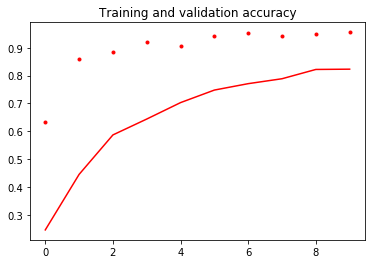

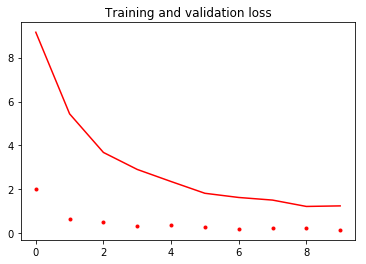

<Figure size 432x288 with 0 Axes>

In [0]:
vgg16_model = VGG16(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))
model(vgg16_model)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Epoch 1/10
93/93 [==============================] - 868s 9s/step - loss: 2.4050 - acc: 0.3576 - val_loss: 0.7101 - val_acc: 0.7731
Epoch 2/10
93/93 [==============================] - 801s 9s/step - loss: 1.1441 - acc: 0.6198 - val_loss: 0.4008 - val_acc: 0.8705
Epoch 3/10
93/93 [==============================] - 794s 9s/step - loss: 0.8189 - acc: 0.7230 - val_loss: 0.2990 - val_acc: 0.9220
Epoch 4/10
93/93 [==============================] - 821s 9s/step - loss: 0.6095 - acc: 0.7917 - val_loss: 0.2385 - val_acc: 0.9192
Epoch 5/10
93/93 [==============================] - 798s 9s/step - loss: 0.5243 - acc: 0.8209 - val_loss: 0.2445 - val_acc: 0.9234
Epoch 6/10
93/93 [==============================] - 803s 9s/step - loss: 0.4519 - acc: 0.8530 - val_loss: 0.1934 - val_acc: 0.9429
Epoch 7/10
93/93 [==============================] - 807s 9s/step - loss: 0.3908 - acc: 0.8678 - val_loss: 0.1760 - val_acc: 0.9443
Epoch 8/10
93/93 [==============================] - 809s 9s/step - loss: 0.3516 - a

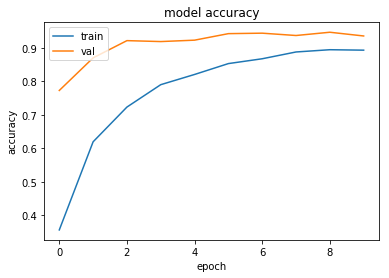

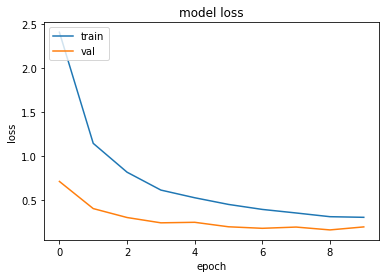

23/23 [==============================] - 155s 7s/step


ValueError: ignored

<Figure size 432x288 with 0 Axes>

In [0]:
resnet50_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))
model(resnet50_model)